In [1]:
%load_ext autoreload

In [2]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-13 06:36:16.417257: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [3]:
from yomi_skill.models.elo_only import EloOnly
from yomi_skill.models.char_skill_elo_skill_deficit_pymc import CharSkillEloSkillDeficitPyMC
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
data_name, hist_games = historical_record.games(autodata="same")
fit_dir = f"fits/{data_name}"

In [5]:
min_games = 30
warmup = 500
samples = 1000

In [6]:
hist_games

,tournament_name,match_date,player_1,character_1,win,character_2,player_2,elo_before_1,elo_after_1,elo_before_2,elo_after_2,player_character_1,player_character_2,glicko_estimate,pc_glicko_estimate,elo_estimate,version_1,version_2
9410,Summer Smash,2014-07-06,ntillerman,Lum,1,Menelker,Felix,1547.833374,1563.039185,1500.000000,1452.000000,ntillerman-Lum,Felix-Menelker,0.500000,0.500000,0.500000,2,2
9411,Summer Smash,2014-07-06,ntillerman,Lum,1,Menelker,Felix,1547.833374,1563.039185,1500.000000,1452.000000,ntillerman-Lum,Felix-Menelker,0.500000,0.500000,0.500000,2,2
9412,Summer Smash,2014-07-06,ntillerman,Lum,1,Menelker,Felix,1547.833374,1563.039185,1500.000000,1452.000000,ntillerman-Lum,Felix-Menelker,0.500000,0.500000,0.500000,2,2
9413,Summer Smash,2014-07-06,ntillerman,Argagarg,1,Menelker,Felix,1547.833374,1563.039185,1500.000000,1452.000000,ntillerman-Argagarg,Felix-Menelker,0.500000,0.500000,0.500000,2,2
9418,Summer Smash,2014-07-06,Djister,Rook,0,Zane,Bob199,1500.125000,1500.625000,1604.313843,1620.398193,Djister-Rook,Bob199-Zane,0.500000,0.500000,0.500000,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17711,IYL Season 9,2021-08-03,mastrblastr,Geiger,0,Zane,cpat,2154.000000,2142.000000,2550.276855,2562.647949,mastrblastr-Geiger,cpat-Zane,0.125965,0.056126,0.334642,2,2
17712,IYL Season 9,2021-08-03,mastrblastr,Onimaru,0,Zane,cpat,2154.000000,2142.000000,2550.276855,2562.647949,mastrblastr-Onimaru,cpat-Zane,0.125965,0.326032,0.334642,2,2
17713,IYL Season 9,2021-08-03,mastrblastr,DeGrey,0,Zane,cpat,2154.000000,2142.000000,2550.276855,2562.647949,mastrblastr-DeGrey,cpat-Zane,0.125965,0.108867,0.334642,2,2
25277,IYL Season 9,2021-08-03,mastrblastr,Geiger,1,Jaina,cpat,2154.000000,2142.000000,2550.276855,2562.647949,mastrblastr-Geiger,cpat-Jaina,0.125965,0.196307,0.334642,2,2


In [20]:
elo_threshold = pandas.concat([hist_games.elo_before_1, hist_games.elo_before_2]).quantile(0.9)
hist_games['has_high_skill'] = (hist_games.elo_before_1 > elo_threshold) | (hist_games.elo_before_2 > elo_threshold)
hist_games['has_low_skill'] = (hist_games.elo_before_1 <= elo_threshold) | (hist_games.elo_before_2 <= elo_threshold)
max_elo = pandas.concat([hist_games.elo_before_1, hist_games.elo_before_2]).max()
min_elo = pandas.concat([hist_games.elo_before_1, hist_games.elo_before_2]).min()
hist_games['weight'] = ((hist_games.elo_before_1-min_elo)/(max_elo-min_elo) * (hist_games.elo_before_2-min_elo)/(max_elo-min_elo))**2

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    hist_games, hist_games.win, test_size=0.8, random_state=42
)

In [9]:
elo_only = EloOnly(
    fit_dir,
    min_games,
    warmup=warmup,
    samples=samples,
)

In [10]:
full = CharSkillEloSkillDeficitPyMC(
    fit_dir,
    min_games,
    warmup=warmup,
    samples=samples,
)

In [11]:

clf_list = [
    (elo_only, "Elo Only"),
    (full, "Char Skill Elo Skill Deficit"),
]
test_subsets = [
    (True, False, "Low/Low"),
    (True, True, "Low/High"),
    (False, True, "High/High"),
]

/home/cpennington/projects/yomi-skill/.venv/lib/python3.10/site-packages/pandas/core/groupby/groupby.py:3212: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(


Compiling...
Compilation time =  0:00:00.834725
Sampling...
Sampling time =  0:00:03.527379
Transforming variables...
Transformation time =  0:00:00.997829


/home/cpennington/projects/yomi-skill/.venv/lib/python3.10/site-packages/pandas/core/groupby/groupby.py:3212: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(


Compiling...
Compilation time =  0:00:00.679086
Sampling...
Sampling time =  0:00:03.850023
Transforming variables...
Transformation time =  0:00:01.081159


/home/cpennington/projects/yomi-skill/.venv/lib/python3.10/site-packages/pandas/core/groupby/groupby.py:3212: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(


int64
int64
Compiling...
Compilation time =  0:00:01.482257
Sampling...
Sampling time =  0:00:05.871546
Transforming variables...
Transformation time =  0:00:26.663563


/home/cpennington/projects/yomi-skill/.venv/lib/python3.10/site-packages/pandas/core/groupby/groupby.py:3212: RuntimeWarning: invalid value encountered in cast
  vals = vals.astype("i8").view(


int64
int64
Compiling...
Compilation time =  0:00:01.634849
Sampling...
Sampling time =  0:00:06.688688
Transforming variables...
Transformation time =  0:00:24.672340


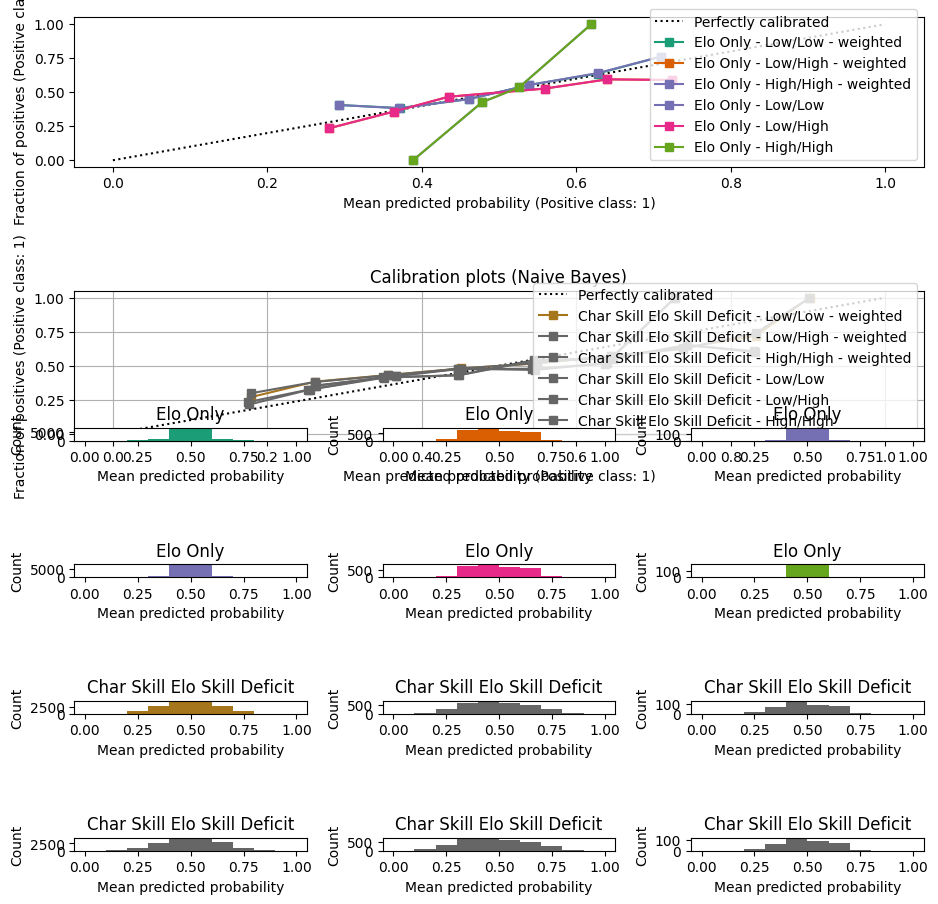

In [15]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4*len(clf_list), 3)
colors = plt.get_cmap("Dark2")

calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    ax_calibration_curve = fig.add_subplot(gs[2*i:2*i+2, :3])
    for w, weighted in enumerate([True, False]):
        clf.fit(X_train, y_train, sample_weights=X_train.weight)
        for t, (low, high, lowhigh) in enumerate(test_subsets):
            label = f"{name} - {lowhigh} - weighted" if weighted else f"{name} - {lowhigh}"
            display = CalibrationDisplay.from_estimator(
                clf,
                X_test[(X_test.has_low_skill == low) & (X_test.has_high_skill == high)],
                y_test[(X_test.has_low_skill == low) & (X_test.has_high_skill == high)],
                n_bins=10,
                name=label,
                ax=ax_calibration_curve,
                color=colors(6*i + 2*w + t),
            )
            calibration_displays[label] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
for r, (_, name) in enumerate(clf_list):
    for w, weighted in enumerate([True, False]):
        row = 3+2*r+w
        for c, (low, high, lowhigh) in enumerate(test_subsets):
            label = f"{name} - {lowhigh} - weighted" if weighted else f"{name} - {lowhigh}"
            col = c
            ax = fig.add_subplot(gs[row, col])
        
            ax.hist(
                calibration_displays[label].y_prob,
                range=(0, 1),
                bins=10,
                label=label,
                color=colors(6*r + 2*w + c),
            )
            ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [17]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

Compiling...
Compilation time =  0:00:00.821917
Sampling...
Sampling time =  0:00:03.990198
Transforming variables...
Transformation time =  0:00:04.688451
Compiling...
Compilation time =  0:00:00.883360
Sampling...
Sampling time =  0:00:06.879154
Transforming variables...
Transformation time =  0:00:05.681788
Compiling...
Compilation time =  0:00:01.400637
Sampling...
Sampling time =  0:00:05.161272
Transforming variables...
Transformation time =  0:00:03.916401
Compiling...
Compilation time =  0:00:00.773305
Sampling...
Sampling time =  0:00:08.082895
Transforming variables...
Transformation time =  0:00:07.298580
Compiling...
Compilation time =  0:00:00.871957
Sampling...
Sampling time =  0:00:04.224385
Transforming variables...
Transformation time =  0:00:03.258859


,fit_time,score_time,test_neg_brier_score,test_neg_log_loss,test_roc_auc,test_precision,test_recall,test_f1
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,12.829666,0.027704,-0.244670,-0.682372,0.583598,0.563080,0.547193,0.554823
std,3.095441,0.003904,0.000807,0.001657,0.005043,0.006667,0.018558,0.007813
min,9.838730,0.024537,-0.245599,-0.684269,0.578499,0.554756,0.524834,0.545025
25%,10.561659,0.025833,-0.245411,-0.683897,0.578648,0.557425,0.536646,0.550903
50%,11.731822,0.026476,-0.244511,-0.682078,0.584315,0.565939,0.548427,0.552890
75%,14.818981,0.027211,-0.244030,-0.681005,0.586367,0.566831,0.551553,0.560842
max,17.197141,0.034462,-0.243800,-0.680611,0.590159,0.570450,0.574503,0.564457


In [18]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

Compiling...
Compilation time =  0:00:00.688684
Sampling...
Sampling time =  0:00:03.718768
Transforming variables...
Transformation time =  0:00:03.137284
Compiling...
Compilation time =  0:00:00.709070
Sampling...
Sampling time =  0:00:03.928544
Transforming variables...
Transformation time =  0:00:03.079859
Compiling...
Compilation time =  0:00:00.709089
Sampling...
Sampling time =  0:00:04.218290
Transforming variables...
Transformation time =  0:00:02.963844
Compiling...
Compilation time =  0:00:00.697406
Sampling...
Sampling time =  0:00:04.109197
Transforming variables...
Transformation time =  0:00:03.254572
Compiling...
Compilation time =  0:00:00.683840
Sampling...
Sampling time =  0:00:04.408538
Transforming variables...
Transformation time =  0:00:03.239157


,fit_time,score_time,test_neg_brier_score,test_neg_log_loss,test_roc_auc,test_precision,test_recall,test_f1
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,8.953647,0.023012,-0.244669,-0.682369,0.583598,0.563080,0.547193,0.554823
std,0.275066,0.001880,0.000806,0.001655,0.005043,0.006667,0.018558,0.007813
min,8.553886,0.021375,-0.245595,-0.684261,0.578499,0.554756,0.524834,0.545025
25%,8.869297,0.021772,-0.245410,-0.683897,0.578648,0.557425,0.536646,0.550903
50%,8.980726,0.022017,-0.244509,-0.682073,0.584315,0.565939,0.548427,0.552890
75%,9.058570,0.024100,-0.244031,-0.681008,0.586367,0.566831,0.551553,0.560842
max,9.305754,0.025796,-0.243799,-0.680608,0.590159,0.570450,0.574503,0.564457


In [19]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

int64
int64
Compiling...
Compilation time =  0:00:01.526528
Sampling...
Sampling time =  0:00:05.844122
Transforming variables...
Transformation time =  0:01:43.995009
int64
int64
Compiling...
Compilation time =  0:00:02.074563
Sampling...
Sampling time =  0:00:07.076952
Transforming variables...
Transformation time =  0:01:33.899524
int64
int64
Compiling...
Compilation time =  0:00:02.068776
Sampling...
Sampling time =  0:00:07.065573
Transforming variables...
Transformation time =  0:01:39.475892
int64
int64
Compiling...
Compilation time =  0:00:01.912098
Sampling...
Sampling time =  0:00:07.561193
Transforming variables...
Transformation time =  0:01:32.590077
int64
int64
Compiling...
Compilation time =  0:00:01.836306
Sampling...
Sampling time =  0:00:06.739620
Transforming variables...
Transformation time =  0:01:34.663890


,fit_time,score_time,test_neg_brier_score,test_neg_log_loss,test_roc_auc,test_precision,test_recall,test_f1
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,107.058051,6.930070,-0.246808,-0.687961,0.593581,0.564181,0.561682,0.562782
std,3.941528,0.563684,0.001692,0.003642,0.007045,0.004691,0.018327,0.008774
min,103.305304,6.442153,-0.248294,-0.691088,0.585980,0.557096,0.538079,0.551198
25%,104.770267,6.564368,-0.248288,-0.690724,0.587445,0.562302,0.550725,0.559176
50%,104.809848,6.745576,-0.246861,-0.688858,0.593102,0.564972,0.565397,0.561216
75%,109.894838,7.045222,-0.246413,-0.686999,0.599731,0.567891,0.567702,0.568172
max,112.509997,7.853032,-0.244182,-0.682136,0.601647,0.568644,0.586507,0.574149


In [21]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

int64
int64
Compiling...
Compilation time =  0:00:01.943010
Sampling...
Sampling time =  0:00:06.142354
Transforming variables...
Transformation time =  0:01:37.406046
int64
int64
Compiling...
Compilation time =  0:00:02.018258
Sampling...
Sampling time =  0:00:06.613560
Transforming variables...
Transformation time =  0:01:33.709992
int64
int64
Compiling...
Compilation time =  0:00:02.157341
Sampling...
Sampling time =  0:00:06.427457
Transforming variables...
Transformation time =  0:01:31.633861
int64
int64
Compiling...
Compilation time =  0:00:02.014772
Sampling...
Sampling time =  0:00:07.608476
Transforming variables...
Transformation time =  0:01:37.544503
int64
int64
Compiling...
Compilation time =  0:00:02.073130
Sampling...
Sampling time =  0:00:06.881500
Transforming variables...
Transformation time =  0:01:37.561165


,fit_time,score_time,test_neg_brier_score,test_neg_log_loss,test_roc_auc,test_precision,test_recall,test_f1
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,105.785417,6.918268,-0.246828,-0.688005,0.593527,0.565107,0.562096,0.563453
std,2.807464,0.372651,0.001686,0.003620,0.007130,0.005179,0.018572,0.009245
min,102.157979,6.643306,-0.248326,-0.691068,0.585804,0.556596,0.538907,0.552046
25%,103.573629,6.674356,-0.248291,-0.690797,0.587401,0.564715,0.549482,0.558854
50%,106.600376,6.730778,-0.246841,-0.688824,0.592930,0.565841,0.565811,0.561166
75%,107.988253,7.010920,-0.246472,-0.687144,0.599892,0.568552,0.569358,0.569594
max,108.606845,7.531978,-0.244208,-0.682190,0.601609,0.569830,0.586921,0.575604
